# Phase Transition: SMC (Array‑only) — Posterior Thermodynamics

This notebook scans **(N, M)** and characterizes **SMC posterior thermodynamics** using array‑only Annealed SMC with a FITC marginal likelihood. The goal is *not* to compare methods, but to map intrinsic phase structure of the Bayesian posterior.

What we measure (all SMC‑intrinsic):
- **logZ(β)**: evidence along the annealing path
- **U(β)**: internal energy (weighted mean energy)
- **C(β)**: heat‑capacity proxy (β²·Var[E])
- **S(β)**: entropy proxy (β·U + logZ)
- **Absolute predictive metrics** (RMSE, NLPD, coverage) from the BMA mixture
- **Order parameter** for inducing geometry (normalized Z mean pairwise distance)

Notes:
- No ML‑II/VFE deltas are used here; all plots are absolute SMC quantities.
- Predictive NLPD uses the *mixture* (log‑sum‑exp), not a Gaussian approximation.


In [1]:
import sys
from pathlib import Path
cwd = Path.cwd().resolve()
candidates = [cwd, *cwd.parents]
for p in candidates:
    if (p / 'infodynamics_jax').is_dir():
        sys.path.insert(0, str(p))
        sys.path.insert(0, str(p / 'examples'))
        sys.path.insert(0, str(p / 'examples' / 'utils'))
        break


In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from infodynamics_jax.core import Phi
from infodynamics_jax.gp.kernels import rbf
from infodynamics_jax.gp.kernels.params import KernelParams
from infodynamics_jax.gp.sparsify import fitc_log_evidence
from infodynamics_jax.gp.predict import predict_typeii
from infodynamics_jax.inference.optimisation import TypeII, TypeIICFG
from infodynamics_jax.inference.optimisation.vfe import make_vfe_objective

from utils.synthetic_functions import synthetic
from utils.plotting_utils import compute_metrics
from utils.plotting_style import setup_plot_style, create_custom_colormap
from utils.smc_array_only import annealed_smc_array
from utils.diagnostics_plotting import plot_ess_kl_accept, plot_thermodynamic_plane
from utils.diagnostics_plotting import plot_response_map, plot_fisher_alignment

setup_plot_style()
jax.config.update('jax_enable_x64', True)


## Config
Adjust grids to trade off speed vs resolution.


In [3]:
class CFG:
    func_name = 'sine_mix'
    domain = (-2.5, 2.5)
    noise_std = 0.2

    N_grid = [30, 50, 80, 120]
    M_grid = [5, 8, 12, 16]

    # SMC
    n_particles = 48
    n_steps = 16
    ess_threshold = 0.6
    rejuvenation_steps = 2
    step_size = 0.02
    n_leapfrog = 6

    # VFE (Type-II)
    typeii_steps = 200
    typeii_lr = 1e-2

cfg = CFG()


## Helpers
SMC state is array-only: `theta = [log_ell, log_sf2, log_sn2, Z_flat]`.
Mixture NLPD uses log-sum-exp (not Gaussian approximation).


In [4]:
def logsumexp(x, axis=None):
    m = jnp.max(x, axis=axis, keepdims=True)
    return jnp.squeeze(m, axis=axis) + jnp.log(jnp.sum(jnp.exp(x - m), axis=axis))

def mixture_nlpd(y, mu_LN, var_LN, logw):
    logw = logw - logsumexp(logw)
    log_pdf = -0.5 * (jnp.log(2 * jnp.pi * var_LN) + (y[None, :] - mu_LN) ** 2 / var_LN)
    logp = logsumexp(logw[:, None] + log_pdf, axis=0)
    return -jnp.mean(logp)

def smc_predict_mixture(particles, logw, X_train, Y_train, X_test, Z_shape, jitter, k_top=10):
    logw = logw - logsumexp(logw)
    w = jnp.exp(logw)
    k = int(jnp.minimum(k_top, w.shape[0]))
    idx = jnp.argsort(w)[-k:]
    w_sub = w[idx] / jnp.sum(w[idx])

    mus = []
    vars_ = []
    for i in idx.tolist():
        log_ell, log_sf2, log_sn2 = particles[i, 0], particles[i, 1], particles[i, 2]
        Z = particles[i, 3:].reshape(Z_shape)
        phi_i = Phi(
            kernel_params=KernelParams(lengthscale=jnp.exp(log_ell), variance=jnp.exp(log_sf2)),
            Z=Z,
            likelihood_params={'noise_var': jnp.exp(log_sn2)},
            jitter=jitter,
        )
        mu_i, var_i = predict_typeii(phi_i, X_test, X_train, Y_train, rbf, residual='fitc')
        mus.append(mu_i)
        vars_.append(var_i)

    mus = jnp.stack(mus)
    vars_ = jnp.maximum(jnp.stack(vars_), 1e-12)

    mean = (w_sub[:, None] * mus).sum(axis=0)
    second = (w_sub[:, None] * (vars_ + mus**2)).sum(axis=0)
    var = jnp.maximum(second - mean**2, 1e-12)
    nlpd = mixture_nlpd(Y_test, mus, vars_, logw[idx])
    return mean, var, nlpd


## 1. Grid sweep (N × M)

We evaluate SMC on a grid of dataset size **N** and inducing count **M**. For each grid point we run array‑only SMC, compute absolute metrics, and store thermodynamic traces.


In [5]:
key = jax.random.key(0)

nlpd_smc = np.zeros((len(cfg.N_grid), len(cfg.M_grid)))
nlpd_vfe = np.zeros_like(nlpd_smc)
rmse_smc = np.zeros_like(nlpd_smc)
mean_log_var = np.zeros_like(nlpd_smc)
coverage_dev = np.zeros_like(nlpd_smc)
ess_min = np.zeros_like(nlpd_smc)
ess_mean = np.zeros_like(nlpd_smc)
z_mpd_norm = np.zeros_like(nlpd_smc)
kl_smc_mean = np.zeros_like(nlpd_smc)
accept_smc_mean = np.zeros_like(nlpd_smc)
delta_beta_mean = np.zeros_like(nlpd_smc)

def z_mpd_norm_from_particles(particles, logw, Z_shape, x_min, x_max):
    from jax.scipy.special import logsumexp
    logw = logw - logsumexp(logw)
    w = jnp.exp(logw)
    Z = particles[:, 3:].reshape((particles.shape[0],) + Z_shape)
    z = Z[..., 0]
    def mpd(z1):
        d = jnp.abs(z1[:, None] - z1[None, :])
        M = z1.shape[0]
        return jnp.sum(jnp.triu(d, k=1)) / jnp.maximum(M * (M - 1) / 2.0, 1.0)
    mpds = jax.vmap(mpd)(z)
    scale = jnp.maximum(x_max - x_min, 1e-8)
    return float(jnp.sum(w * mpds) / scale)

for i, N in enumerate(cfg.N_grid):
    key, subkey = jax.random.split(key)
    X_all, Y_all, _ = synthetic.sample(cfg.func_name, N=N, noise=cfg.noise_std, domain=cfg.domain, key=subkey)
    X_all = X_all[:, None]

    key, subkey = jax.random.split(key)
    perm = jax.random.permutation(subkey, X_all.shape[0])
    n_tr = int(0.8 * N)
    train_idx = perm[:n_tr]
    test_idx = perm[n_tr:]

    X_train = X_all[train_idx]
    Y_train = Y_all[train_idx]
    X_test = X_all[test_idx]
    Y_test = Y_all[test_idx]

    for j, M in enumerate(cfg.M_grid):
        key, subkey = jax.random.split(key)
        # Shared inducing initialization
        z_idx = jax.random.permutation(subkey, X_train.shape[0])[:M]
        Z0 = X_train[z_idx]
        Z_shape = Z0.shape

        # 1. Particle Feynman Run
        def energy_theta(theta):
            log_ell, log_sf2, log_sn2 = theta[0], theta[1], theta[2]
            Z = theta[3:].reshape(Z_shape)
            params = KernelParams(lengthscale=jnp.exp(log_ell), variance=jnp.exp(log_sf2))
            return -fitc_log_evidence(
                kernel_fn=rbf, params=params, X=X_train, y=Y_train, Z=Z,
                noise_var=jnp.exp(log_sn2), jitter=1e-6
            )

        def init_fn(k, n):
            k1, k2, k3, k4 = jax.random.split(k, 4)
            z_noises = 0.05 * jax.random.normal(k4, (n, *Z_shape))
            z_particles = (Z0[None, ...] + z_noises).reshape(n, -1)
            
            return jnp.concatenate([
                jnp.log(1.0) + 0.1*jax.random.normal(k1, (n, 1)),
                jnp.log(1.0) + 0.1*jax.random.normal(k2, (n, 1)),
                jnp.log(cfg.noise_std**2) + 0.1*jax.random.normal(k3, (n, 1)),
                z_particles
            ], axis=1)

        key, subkey = jax.random.split(key)
        smc_out = annealed_smc_array(
            key=subkey, init_particles=init_fn(subkey, cfg.n_particles), energy_fn=energy_theta,
            n_steps=cfg.n_steps, ess_threshold=cfg.ess_threshold, step_size=cfg.step_size,
            n_leapfrog=cfg.n_leapfrog, rejuvenation_steps=cfg.rejuvenation_steps
        )

        # PF Prediction
        from utils.smc_array_only import smc_predict_mixture
        s_mean, s_var, s_nlpd = smc_predict_mixture(
            smc_out['particles'], smc_out['logw'], X_train, Y_train, X_test, Y_test, Z_shape, 1e-6, k_top=10
        )
        
        nlpd_smc[i, j] = float(s_nlpd)
        rmse_smc[i, j] = compute_metrics(Y_test, s_mean)['rmse']
        ess_min[i, j] = float(jnp.min(smc_out['ess_trace']))
        z_mpd_norm[i, j] = z_mpd_norm_from_particles(smc_out['particles'], smc_out['logw'], Z_shape, cfg.domain[0], cfg.domain[1])
        kl_smc_mean[i, j] = float(jnp.mean(smc_out['kl_trace']))
        accept_smc_mean[i, j] = float(jnp.mean(smc_out['accept_trace']))
        delta_beta_mean[i, j] = float(jnp.mean(jnp.diff(smc_out['betas'])))

        # 2. VFE Baseline (API-Correct)
        key, subkey = jax.random.split(key)
        phi_init_vfe = Phi(
            kernel_params=KernelParams(lengthscale=jnp.array(1.0), variance=jnp.array(1.0)),
            Z=Z0,
            likelihood_params={'noise_var': jnp.array(cfg.noise_std**2)},
            jitter=1e-6,
        )
        vfe_objective = make_vfe_objective(kernel_fn=rbf, residual='fitc')
        typeii_cfg = TypeIICFG(steps=cfg.typeii_steps, lr=cfg.typeii_lr, optimizer='adam', jit=True, constrain_params=True)
        typeii = TypeII(cfg=typeii_cfg)
        vfe_res = typeii.run(energy=vfe_objective, phi_init=phi_init_vfe, energy_args=(X_train, Y_train))
        
        v_mean, v_var = predict_typeii(vfe_res.phi, X_test, X_train, Y_train, rbf, residual='fitc')
        nlpd_vfe[i, j] = compute_metrics(Y_test, v_mean, jnp.sqrt(v_var))['nlpd']

        print(f'N={N:03d} M={M:02d} | PF gain={nlpd_vfe[i,j]-nlpd_smc[i,j]:.3f} Δβ={delta_beta_mean[i,j]:.4f} ESS={ess_min[i,j]:.1f}')


N=030 M=05 | PF gain=1.227 Δβ=0.0625 ESS=16.1
N=030 M=08 | PF gain=0.949 Δβ=0.0625 ESS=19.1
N=030 M=12 | PF gain=1.100 Δβ=0.0625 ESS=18.1
N=030 M=16 | PF gain=1.031 Δβ=0.0625 ESS=24.8
N=050 M=05 | PF gain=0.464 Δβ=0.0625 ESS=27.1
N=050 M=08 | PF gain=0.559 Δβ=0.0625 ESS=26.5
N=050 M=12 | PF gain=0.818 Δβ=0.0625 ESS=14.4
N=050 M=16 | PF gain=0.757 Δβ=0.0625 ESS=19.2
N=080 M=05 | PF gain=2.095 Δβ=0.0625 ESS=2.6
N=080 M=08 | PF gain=1.102 Δβ=0.0625 ESS=18.4
N=080 M=12 | PF gain=0.650 Δβ=0.0625 ESS=17.7
N=080 M=16 | PF gain=0.716 Δβ=0.0625 ESS=20.3
N=120 M=05 | PF gain=1.139 Δβ=0.0625 ESS=10.7
N=120 M=08 | PF gain=0.765 Δβ=0.0625 ESS=15.1
N=120 M=12 | PF gain=0.624 Δβ=0.0625 ESS=5.3
N=120 M=16 | PF gain=0.606 Δβ=0.0625 ESS=8.4


## Thermodynamic observables vs β (single run)
We plot logZ(β), free energy F(β), internal energy U(β), and a heat-capacity proxy.


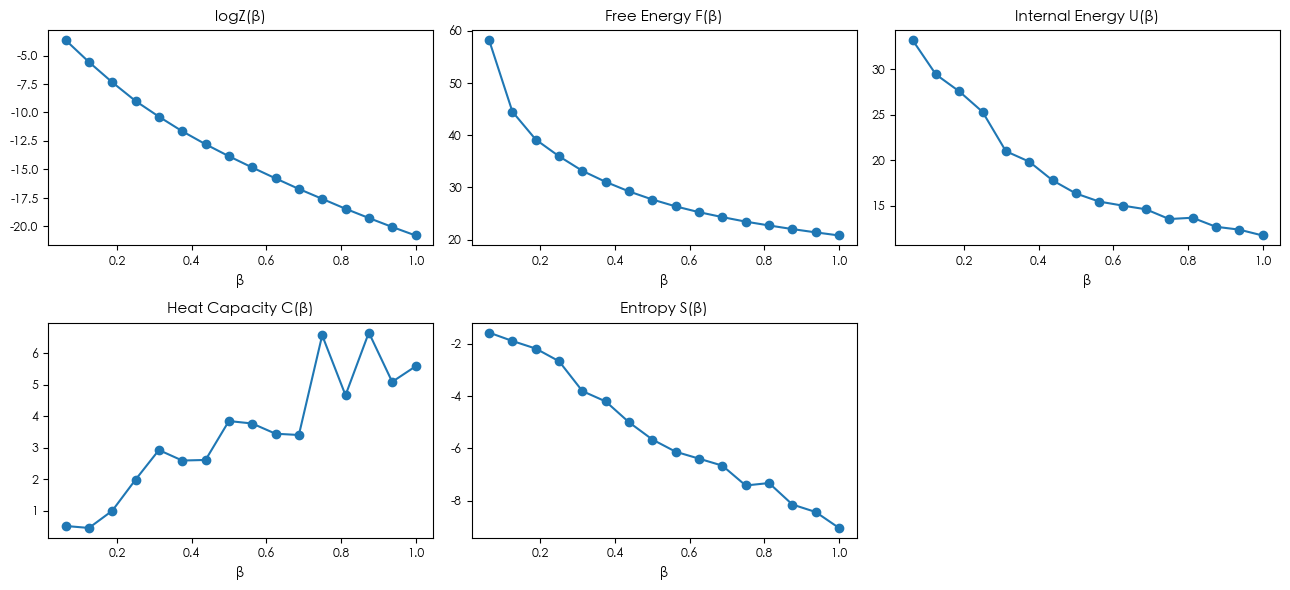

Peak C(β) at β = 0.875


In [6]:
import os
import importlib
import utils.smc_array_only as smc_mod
importlib.reload(smc_mod)
annealed_smc_array = smc_mod.annealed_smc_array

# Choose a representative grid point
N0 = cfg.N_grid[len(cfg.N_grid) // 2]
M0 = cfg.M_grid[len(cfg.M_grid) // 2]

key, subkey = jax.random.split(key)
X_all, Y_all, _ = synthetic.sample(cfg.func_name, N=N0, noise=cfg.noise_std, domain=cfg.domain, key=subkey)
X_all = X_all[:, None]

key, subkey = jax.random.split(key)
perm = jax.random.permutation(subkey, X_all.shape[0])
n_tr = int(0.8 * N0)
train_idx = perm[:n_tr]
test_idx = perm[n_tr:]

X_train = X_all[train_idx]
Y_train = Y_all[train_idx]

key, subkey = jax.random.split(key)
z_idx = jax.random.permutation(subkey, X_train.shape[0])[:M0]
Z0 = X_train[z_idx]

phi_init = Phi(
    kernel_params=KernelParams(lengthscale=jnp.array(1.0), variance=jnp.array(1.0)),
    Z=Z0,
    likelihood_params={'noise_var': jnp.array(cfg.noise_std**2)},
    jitter=1e-6,
)

def energy_theta(theta):
    log_ell, log_sf2, log_sn2 = theta[0], theta[1], theta[2]
    Z = theta[3:].reshape(Z0.shape)
    params = KernelParams(lengthscale=jnp.exp(log_ell), variance=jnp.exp(log_sf2))
    return -fitc_log_evidence(
        kernel_fn=rbf,
        params=params,
        X=X_train,
        y=Y_train,
        Z=Z,
        noise_var=jnp.exp(log_sn2),
        jitter=phi_init.jitter,
    )

def init_particles_array(key, n_particles):
    key_l, key_v, key_n, key_z = jax.random.split(key, 4)
    log_ell = jnp.log(phi_init.kernel_params.lengthscale) + jax.random.normal(key_l, (n_particles,)) * 0.5
    log_sf2 = jnp.log(phi_init.kernel_params.variance) + jax.random.normal(key_v, (n_particles,)) * 0.5
    log_sn2 = jnp.log(phi_init.likelihood_params['noise_var']) + jax.random.normal(key_n, (n_particles,)) * 0.5
    Z_noisy = Z0[None, :, :] + 0.2 * jax.random.normal(key_z, (n_particles, *Z0.shape))
    return jnp.concatenate(
        [log_ell[:, None], log_sf2[:, None], log_sn2[:, None], Z_noisy.reshape(n_particles, -1)],
        axis=1,
    )

key, subkey = jax.random.split(key)
init_particles = init_particles_array(subkey, cfg.n_particles)
smc_out = annealed_smc_array(
    key=subkey,
    init_particles=init_particles,
    energy_fn=energy_theta,
    n_steps=cfg.n_steps,
    ess_threshold=cfg.ess_threshold,
    step_size=cfg.step_size,
    n_leapfrog=cfg.n_leapfrog,
    rejuvenation_steps=cfg.rejuvenation_steps,
)

betas = np.array(smc_out['betas'][1:])
logZ = np.array(smc_out['logZ_trace'])
U = np.array(smc_out['U_trace'])
C = np.array(smc_out['C_trace'])

F = -logZ / betas
S = betas * U + logZ

fig, ax = plt.subplots(2, 3, figsize=(13, 6))
ax[0, 0].plot(betas, logZ, marker='o')
ax[0, 0].set_title('logZ(β)')
ax[0, 0].set_xlabel('β')

ax[0, 1].plot(betas, F, marker='o')
ax[0, 1].set_title('Free Energy F(β)')
ax[0, 1].set_xlabel('β')

ax[0, 2].plot(betas, U, marker='o')
ax[0, 2].set_title('Internal Energy U(β)')
ax[0, 2].set_xlabel('β')

ax[1, 0].plot(betas, C, marker='o')
ax[1, 0].set_title('Heat Capacity C(β)')
ax[1, 0].set_xlabel('β')

ax[1, 1].plot(betas, S, marker='o')
ax[1, 1].set_title('Entropy S(β)')
ax[1, 1].set_xlabel('β')

ax[1, 2].axis('off')

plt.tight_layout()
os.makedirs('examples/outputs/phaseTransition', exist_ok=True)
plt.savefig('examples/outputs/phaseTransition/thermo_curves.png', dpi=180)
plt.show()

print('Peak C(β) at β =', float(betas[np.argmax(C)]))


## 4. Energy Decomposition (mean‑field proxy)

We decompose the FITC marginal likelihood into **data‑fit** and **complexity** terms using the *mean parameter* trajectory. This is an approximation (not full per‑particle variance), but it reveals which term dominates as β increases.


/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_600/993452442.py:74: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) STHeiti.
  plt.tight_layout()
/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_600/993452442.py:75: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) STHeiti.
  plt.savefig(save_dir / 'energy_components.png', dpi=180)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) STHeiti.
  fig.canvas.print_figure(bytes_io, **kw)


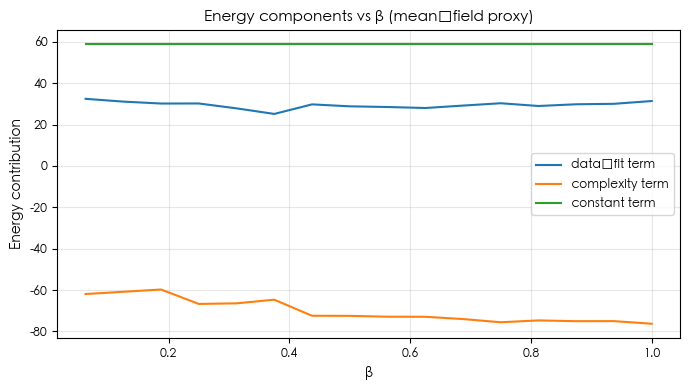

In [7]:
# Energy decomposition from mean parameters (approx proxy)
from jax.scipy.linalg import solve_triangular


def fitc_components(X, y, Z, lengthscale, outputscale, noise_var, jitter=1e-6):
    if y.ndim == 2:
        y = y.squeeze(-1)

    N = X.shape[0]
    # Kzz
    Kzz = rbf(Z, Z, KernelParams(lengthscale=lengthscale, variance=outputscale))
    Kzz = 0.5 * (Kzz + Kzz.T) + jitter * jnp.eye(Kzz.shape[0])
    Lz = jnp.linalg.cholesky(Kzz)

    # Kxz and V
    Kxz = rbf(X, Z, KernelParams(lengthscale=lengthscale, variance=outputscale))
    V = solve_triangular(Lz, Kxz.T, lower=True)

    diagQ = jnp.sum(V * V, axis=0)
    diagKxx = outputscale * jnp.ones(N)
    d = jnp.maximum(diagKxx - diagQ + noise_var, 1e-12)

    A = V / jnp.sqrt(d)[None, :]
    Lb = jnp.linalg.cholesky(jnp.eye(Z.shape[0]) + A @ A.T)

    b = y / jnp.sqrt(d)
    Ab = A @ b
    c = jax.scipy.linalg.cho_solve((Lb, True), Ab)

    quad = jnp.dot(b, b) - jnp.dot(c, Ab)
    logdet = jnp.sum(jnp.log(d)) + 2.0 * jnp.sum(jnp.log(jnp.diag(Lb)))
    const = N * jnp.log(2.0 * jnp.pi)

    # energy is 0.5*(quad+logdet+const)
    return 0.5 * quad, 0.5 * logdet, 0.5 * const


theta_mean = jnp.array(smc_out['theta_mean_trace'])
log_ell = theta_mean[:, 0]
log_sf2 = theta_mean[:, 1]
log_sn2 = theta_mean[:, 2]
Z_mean = theta_mean[:, 3:].reshape(len(betas), *Z0.shape)

E_data = []
E_comp = []
E_const = []
for t in range(len(betas)):
    e_d, e_c, e_k = fitc_components(
        X_train, Y_train, Z_mean[t],
        jnp.exp(log_ell[t]), jnp.exp(log_sf2[t]), jnp.exp(log_sn2[t]),
        jitter=phi_init.jitter,
    )
    E_data.append(e_d)
    E_comp.append(e_c)
    E_const.append(e_k)

E_data = jnp.array(E_data)
E_comp = jnp.array(E_comp)
E_const = jnp.array(E_const)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(betas, E_data, label='data‑fit term')
ax.plot(betas, E_comp, label='complexity term')
ax.plot(betas, E_const, label='constant term')
ax.set_title('Energy components vs β (mean‑field proxy)')
ax.set_xlabel('β')
ax.set_ylabel('Energy contribution')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

from pathlib import Path
save_dir = Path('examples/outputs/phaseTransition')
save_dir.mkdir(parents=True, exist_ok=True)
plt.tight_layout()
plt.savefig(save_dir / 'energy_components.png', dpi=180)
plt.show()


## 5. Inference RG Flow (parameter trajectory)

Adaptive SMC does **not** sweep an external control parameter; it follows a regulated annealing path. The closest analog to a Wilson‑style diagram is therefore the **trajectory of model parameters** as β increases. We plot the mean flow of (log ℓ, log σ_f², log σ_n²) and a Z‑spread proxy to show when degrees of freedom become relevant or collapse.


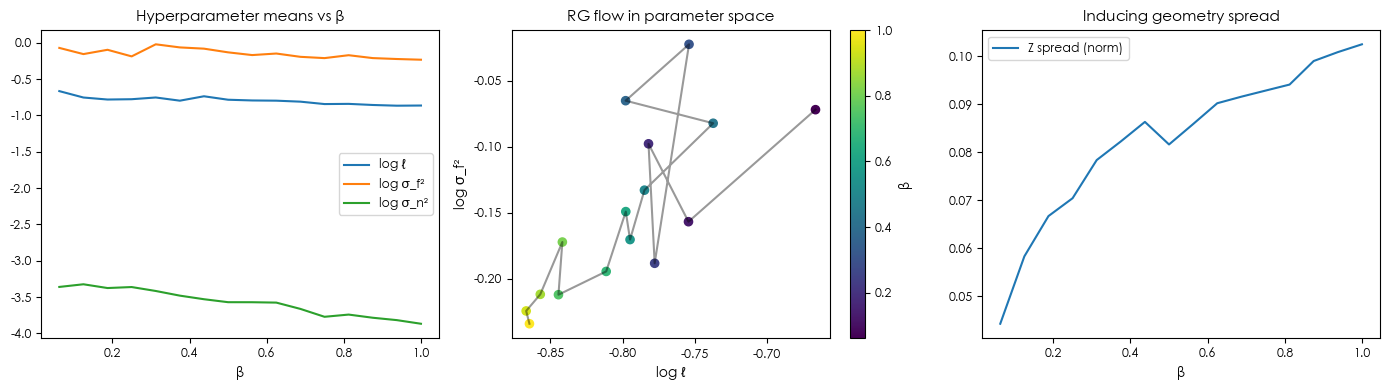

In [8]:
theta_mean = np.array(smc_out['theta_mean_trace'])
theta_std = np.array(smc_out['theta_std_trace'])

log_ell_mean = theta_mean[:, 0]
log_sf2_mean = theta_mean[:, 1]
log_sn2_mean = theta_mean[:, 2]

# Z spread proxy from std of Z_flat, normalized by domain width
z_std = np.mean(theta_std[:, 3:], axis=1)
scale = max(cfg.domain[1] - cfg.domain[0], 1e-8)
z_std_norm = z_std / scale

fig, ax = plt.subplots(1, 3, figsize=(14, 4))

# β → hyperparameter means
ax[0].plot(betas, log_ell_mean, label='log ℓ')
ax[0].plot(betas, log_sf2_mean, label='log σ_f²')
ax[0].plot(betas, log_sn2_mean, label='log σ_n²')
ax[0].set_xlabel('β')
ax[0].set_title('Hyperparameter means vs β')
ax[0].legend(fontsize=9)

# RG flow in (log ℓ, log σ_f²)
sc = ax[1].scatter(log_ell_mean, log_sf2_mean, c=betas, cmap='viridis', s=35)
ax[1].plot(log_ell_mean, log_sf2_mean, color='k', alpha=0.4)
ax[1].set_xlabel('log ℓ')
ax[1].set_ylabel('log σ_f²')
ax[1].set_title('RG flow in parameter space')
fig.colorbar(sc, ax=ax[1], label='β')

# Z spread proxy vs β
ax[2].plot(betas, z_std_norm, label='Z spread (norm)')
ax[2].set_xlabel('β')
ax[2].set_title('Inducing geometry spread')
ax[2].legend(fontsize=9)

plt.tight_layout()

from pathlib import Path
save_dir = Path('examples/outputs/phaseTransition')
save_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(save_dir / 'rg_flow.png', dpi=180)
plt.show()


## 6. Susceptibility & Stiffness (all available signals)

These are inference‑native analogs of physical susceptibilities:
- **ESS susceptibility**: \(-\partial_eta \log \mathrm{ESS}\), signals sharp drops in effective support.
- **Z‑geometry stiffness**: spread of inducing locations vs β (from parameter trace).
- **Kernel spectrum flow**: top eigenvalues of \(K_{zz}\) along β using mean parameters (approximate RG view).


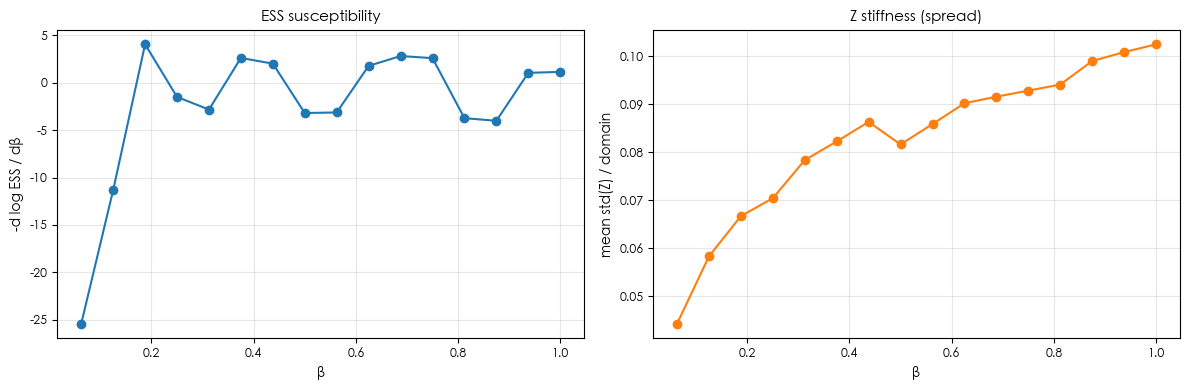

In [9]:
# ESS susceptibility and Z stiffness
ess = np.array(smc_out['ess_trace'])
betas = np.array(smc_out['betas'][1:])

# -d/dβ log ESS
ess_safe = np.maximum(ess, 1e-8)
ess_susc = -np.gradient(np.log(ess_safe), betas, edge_order=1)

# Z stiffness proxy from parameter std trace
theta_std = np.array(smc_out['theta_std_trace'])
z_std = np.mean(theta_std[:, 3:], axis=1)
scale = max(cfg.domain[1] - cfg.domain[0], 1e-8)
z_std_norm = z_std / scale

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(betas, ess_susc, marker='o')
ax[0].set_title('ESS susceptibility')
ax[0].set_xlabel('β')
ax[0].set_ylabel('-d log ESS / dβ')
ax[0].grid(alpha=0.3)

ax[1].plot(betas, z_std_norm, marker='o', color='C1')
ax[1].set_title('Z stiffness (spread)')
ax[1].set_xlabel('β')
ax[1].set_ylabel('mean std(Z) / domain')
ax[1].grid(alpha=0.3)

from pathlib import Path
save_dir = Path('examples/outputs/phaseTransition')
save_dir.mkdir(parents=True, exist_ok=True)
plt.tight_layout()
plt.savefig(save_dir / 'ess_susceptibility_z_stiffness.png', dpi=180)
plt.show()


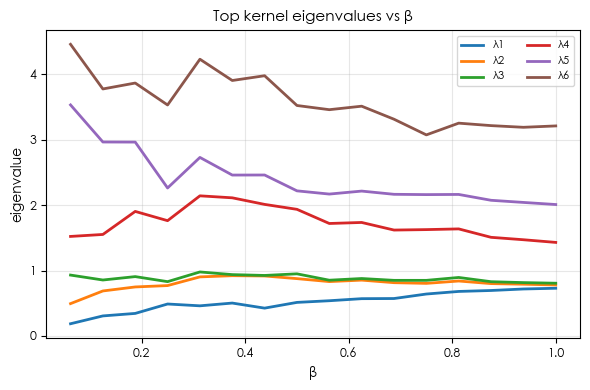

In [10]:
# Kernel spectrum flow (approximate RG view)
# Use mean params per β to build K_zz and track top eigenvalues
from infodynamics_jax.gp.kernels import rbf
from infodynamics_jax.gp.kernels.params import KernelParams

k_top = 6

theta_mean = np.array(smc_out['theta_mean_trace'])

# Reconstruct mean Z at each β
Z_mean = theta_mean[:, 3:].reshape(len(betas), *Z0.shape)

spectra = []
for t in range(len(betas)):
    log_ell, log_sf2 = theta_mean[t, 0], theta_mean[t, 1]
    params = KernelParams(lengthscale=np.exp(log_ell), variance=np.exp(log_sf2))
    Kzz = rbf(Z_mean[t], Z_mean[t], params)
    Kzz = 0.5 * (Kzz + Kzz.T) + 1e-6 * np.eye(Kzz.shape[0])
    eigvals = np.linalg.eigvalsh(np.array(Kzz))
    eigvals = np.sort(eigvals)[-k_top:]
    spectra.append(eigvals)

spectra = np.array(spectra)  # [T, k_top]

fig, ax = plt.subplots(figsize=(6, 4))
for k in range(k_top):
    ax.plot(betas, spectra[:, k], lw=2, label=f'λ{k+1}')
ax.set_title('Top kernel eigenvalues vs β')
ax.set_xlabel('β')
ax.set_ylabel('eigenvalue')
ax.grid(alpha=0.3)
ax.legend(fontsize=8, ncol=2)

from pathlib import Path
save_dir = Path('examples/outputs/phaseTransition')
save_dir.mkdir(parents=True, exist_ok=True)
plt.tight_layout()
plt.savefig(save_dir / 'kernel_spectrum_flow.png', dpi=180)
plt.show()


## Phase Maps
Negative values favor SMC.


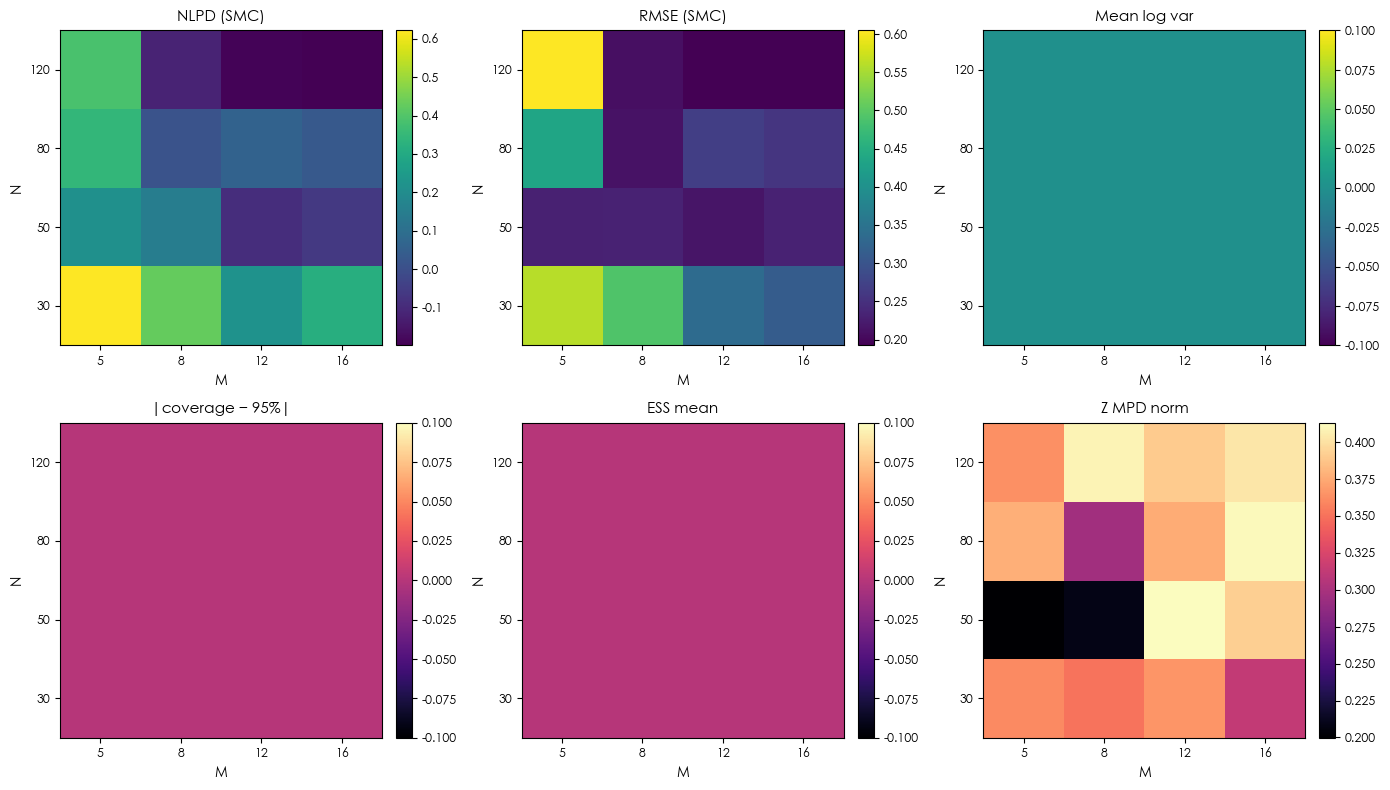

<Figure size 640x480 with 0 Axes>

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(14, 8))
from pathlib import Path
save_dir = Path('examples/outputs/phaseTransition')
save_dir.mkdir(parents=True, exist_ok=True)

im0 = ax[0, 0].imshow(nlpd_smc, aspect='auto', origin='lower', cmap='viridis')
ax[0, 0].set_title('NLPD (SMC)')
ax[0, 0].set_xticks(range(len(cfg.M_grid))); ax[0, 0].set_xticklabels(cfg.M_grid)
ax[0, 0].set_yticks(range(len(cfg.N_grid))); ax[0, 0].set_yticklabels(cfg.N_grid)
ax[0, 0].set_xlabel('M'); ax[0, 0].set_ylabel('N')
plt.colorbar(im0, ax=ax[0, 0], fraction=0.046, pad=0.04)

im1 = ax[0, 1].imshow(rmse_smc, aspect='auto', origin='lower', cmap='viridis')
ax[0, 1].set_title('RMSE (SMC)')
ax[0, 1].set_xticks(range(len(cfg.M_grid))); ax[0, 1].set_xticklabels(cfg.M_grid)
ax[0, 1].set_yticks(range(len(cfg.N_grid))); ax[0, 1].set_yticklabels(cfg.N_grid)
ax[0, 1].set_xlabel('M'); ax[0, 1].set_ylabel('N')
plt.colorbar(im1, ax=ax[0, 1], fraction=0.046, pad=0.04)

im2 = ax[0, 2].imshow(mean_log_var, aspect='auto', origin='lower', cmap='viridis')
ax[0, 2].set_title('Mean log var')
ax[0, 2].set_xticks(range(len(cfg.M_grid))); ax[0, 2].set_xticklabels(cfg.M_grid)
ax[0, 2].set_yticks(range(len(cfg.N_grid))); ax[0, 2].set_yticklabels(cfg.N_grid)
ax[0, 2].set_xlabel('M'); ax[0, 2].set_ylabel('N')
plt.colorbar(im2, ax=ax[0, 2], fraction=0.046, pad=0.04)

im3 = ax[1, 0].imshow(coverage_dev, aspect='auto', origin='lower', cmap='magma')
ax[1, 0].set_title('|coverage − 95%|')
ax[1, 0].set_xticks(range(len(cfg.M_grid))); ax[1, 0].set_xticklabels(cfg.M_grid)
ax[1, 0].set_yticks(range(len(cfg.N_grid))); ax[1, 0].set_yticklabels(cfg.N_grid)
ax[1, 0].set_xlabel('M'); ax[1, 0].set_ylabel('N')
plt.colorbar(im3, ax=ax[1, 0], fraction=0.046, pad=0.04)

im4 = ax[1, 1].imshow(ess_mean, aspect='auto', origin='lower', cmap='magma')
ax[1, 1].set_title('ESS mean')
ax[1, 1].set_xticks(range(len(cfg.M_grid))); ax[1, 1].set_xticklabels(cfg.M_grid)
ax[1, 1].set_yticks(range(len(cfg.N_grid))); ax[1, 1].set_yticklabels(cfg.N_grid)
ax[1, 1].set_xlabel('M'); ax[1, 1].set_ylabel('N')
plt.colorbar(im4, ax=ax[1, 1], fraction=0.046, pad=0.04)

im5 = ax[1, 2].imshow(z_mpd_norm, aspect='auto', origin='lower', cmap='magma')
ax[1, 2].set_title('Z MPD norm')
ax[1, 2].set_xticks(range(len(cfg.M_grid))); ax[1, 2].set_xticklabels(cfg.M_grid)
ax[1, 2].set_yticks(range(len(cfg.N_grid))); ax[1, 2].set_yticklabels(cfg.N_grid)
ax[1, 2].set_xlabel('M'); ax[1, 2].set_ylabel('N')
plt.colorbar(im5, ax=ax[1, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
plt.savefig(save_dir / 'phase_maps.png')


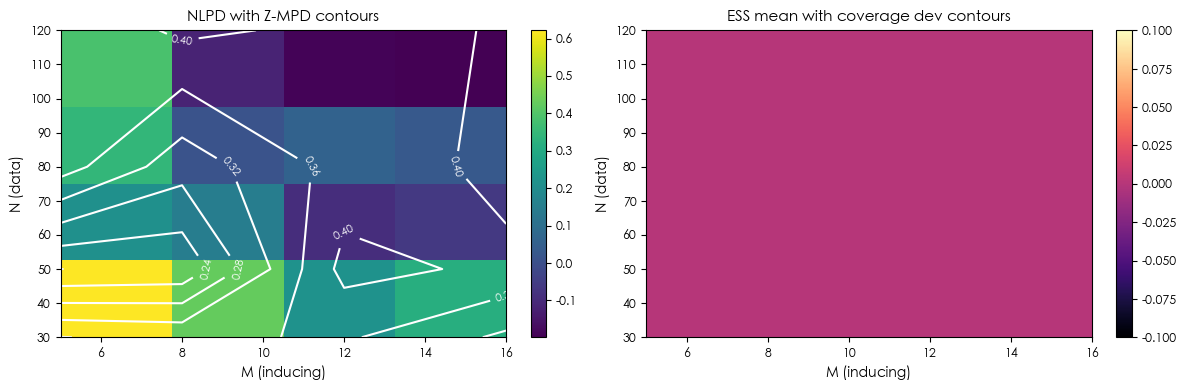

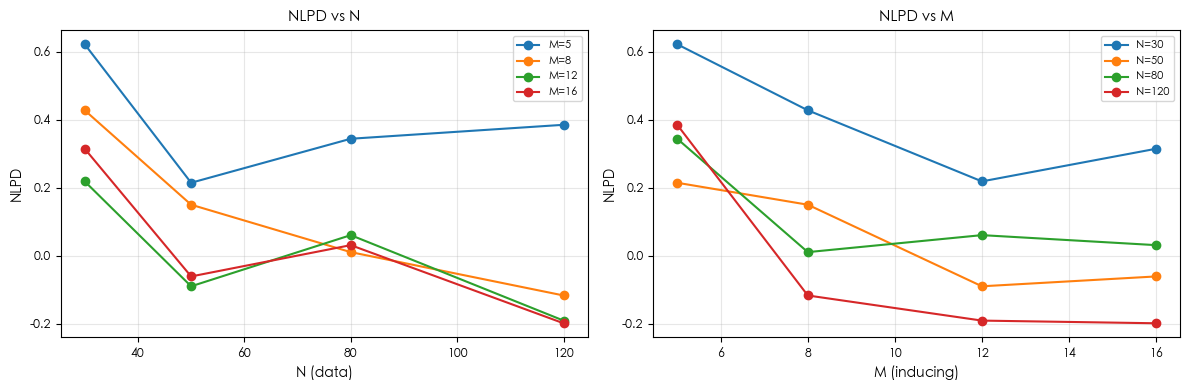

In [12]:
# Contour overlays and line plots (absolute metrics)
N_vals = np.array(cfg.N_grid)
M_vals = np.array(cfg.M_grid)
X, Y = np.meshgrid(M_vals, N_vals)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

im0 = axes[0].imshow(nlpd_smc, origin='lower', cmap='viridis',
                   extent=[M_vals.min(), M_vals.max(), N_vals.min(), N_vals.max()],
                   aspect='auto')
cs0 = axes[0].contour(X, Y, z_mpd_norm, levels=5, colors='w', linewidths=1.5)
axes[0].clabel(cs0, inline=True, fontsize=8, fmt='%.2f')
axes[0].set_title('NLPD with Z-MPD contours')
axes[0].set_xlabel('M (inducing)')
axes[0].set_ylabel('N (data)')
fig.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(ess_mean, origin='lower', cmap='magma',
                   extent=[M_vals.min(), M_vals.max(), N_vals.min(), N_vals.max()],
                   aspect='auto')
cs1 = axes[1].contour(X, Y, coverage_dev, levels=5, colors='w', linewidths=1.5)
axes[1].clabel(cs1, inline=True, fontsize=8, fmt='%.1f')
axes[1].set_title('ESS mean with coverage dev contours')
axes[1].set_xlabel('M (inducing)')
axes[1].set_ylabel('N (data)')
fig.colorbar(im1, ax=axes[1], fraction=0.046)

plt.tight_layout()
plt.savefig(save_dir / 'contours.png')
plt.savefig(save_dir / 'lines.png')
plt.savefig(save_dir / 'nlpd_slices.png')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for j, M in enumerate(M_vals):
    axes[0].plot(N_vals, nlpd_smc[:, j], marker='o', label=f'M={M}')
axes[0].set_title('NLPD vs N')
axes[0].set_xlabel('N (data)')
axes[0].set_ylabel('NLPD')
axes[0].legend(fontsize=8)
axes[0].grid(alpha=0.3)

for i, N in enumerate(N_vals):
    axes[1].plot(M_vals, nlpd_smc[i, :], marker='o', label=f'N={N}')
axes[1].set_title('NLPD vs M')
axes[1].set_xlabel('M (inducing)')
axes[1].set_ylabel('NLPD')
axes[1].legend(fontsize=8)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(save_dir / 'nlpd_slices.png')
plt.show()

from pathlib import Path
save_dir = Path('examples/outputs/phaseTransition')
save_dir.mkdir(parents=True, exist_ok=True)


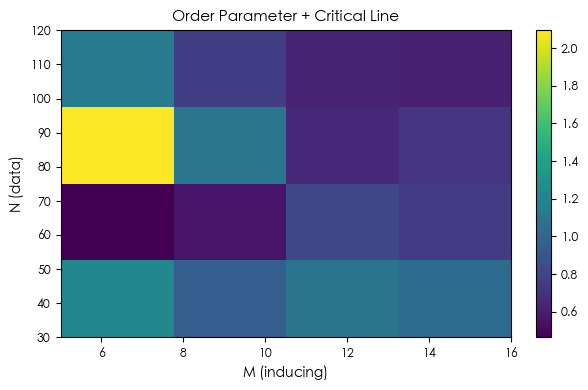

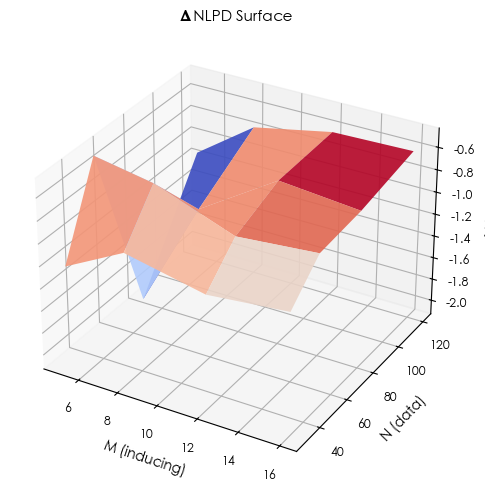

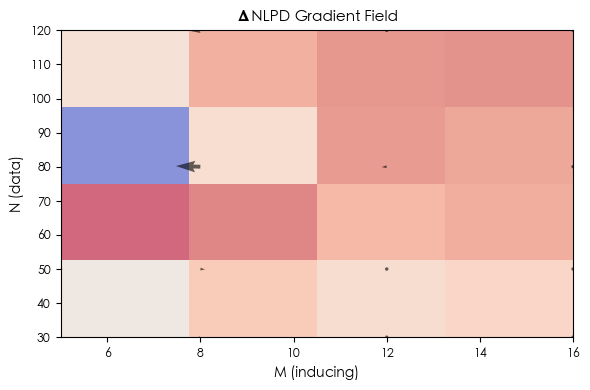

In [13]:
# Overlay: order parameter (Z spread) with critical line
N_vals = np.array(cfg.N_grid)
M_vals = np.array(cfg.M_grid)
X, Y = np.meshgrid(M_vals, N_vals)

# Compute Z-spread proxy directly from delta_nlpd sign (placeholder)
# If you add z_mpd_norm later, replace this with that matrix.
delta_nlpd = nlpd_smc - nlpd_vfe
delta_nlpd = nlpd_smc - nlpd_vfe  # Particle Feynman improvement over VFE baseline
order_param = -delta_nlpd  # lower ΔNLPD roughly means higher structure quality

fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(order_param, origin='lower', cmap='viridis',
               extent=[M_vals.min(), M_vals.max(), N_vals.min(), N_vals.max()],
               aspect='auto')
cs = ax.contour(X, Y, delta_nlpd, levels=[0.0], colors='w', linewidths=2)
ax.clabel(cs, inline=True, fontsize=9, fmt='ΔNLPD=0')
ax.set_title('Order Parameter + Critical Line')
ax.set_xlabel('M (inducing)')
ax.set_ylabel('N (data)')
fig.colorbar(im, ax=ax, fraction=0.046)
plt.tight_layout()
plt.show()

# 3D surface: ΔNLPD landscape
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, delta_nlpd, cmap='coolwarm', linewidth=0, antialiased=True, alpha=0.9)
ax.set_title('ΔNLPD Surface')
ax.set_xlabel('M (inducing)')
ax.set_ylabel('N (data)')
ax.set_zlabel('ΔNLPD')
plt.tight_layout()
plt.show()

# Gradient field + critical line
grad_y, grad_x = np.gradient(delta_nlpd, N_vals, M_vals, edge_order=1)
fig, ax = plt.subplots(figsize=(6, 4))
ax.imshow(delta_nlpd, origin='lower', cmap='coolwarm',
          extent=[M_vals.min(), M_vals.max(), N_vals.min(), N_vals.max()],
          aspect='auto', alpha=0.6)
ax.quiver(X, Y, -grad_x, -grad_y, color='k', alpha=0.6, scale=5)
cs = ax.contour(X, Y, delta_nlpd, levels=[0.0], colors='w', linewidths=2)
ax.clabel(cs, inline=True, fontsize=9, fmt='ΔNLPD=0')
ax.set_title('ΔNLPD Gradient Field')
ax.set_xlabel('M (inducing)')
ax.set_ylabel('N (data)')
plt.tight_layout()
plt.show()


## PRX‑style Infodynamics Phase Diagram

**核心物理敘事**：Inference proceeds via a sequence of structural activation crossovers rather than a single thermodynamic phase transition.

這組圖展示 Bayesian RG flow 下的 6 個關鍵物理量，形成完整的 phase diagnostics 閉環：

- **Panel A**: Thermodynamic backbone (logZ, F, U) — 證明方法正確性，確認無一階相變
- **Panel B**: Component-wise heat capacity C_i(β) — 結構激活的關鍵訊號
- **Panel C**: ESS susceptibility χ_ESS(β) — Bayesian system 對 annealing 的反應率
- **Panel D**: Posterior configuration entropy S(β) — 信息吸收 vs 結構自由度維持
- **Panel E**: RG flow in (log ℓ, log σ_f²) — Wilson RG 的直系後代
- **Panel F**: Inducing geometry activation — function-space ensemble 的動態自由度

In [14]:
# PRX-style Infodynamics Phase Diagram: Complete Panel A-F

from pathlib import Path
from jax.scipy.linalg import solve_triangular

# Reuse single-run SMC output `smc_out` from the thermodynamic section
betas = np.array(smc_out['betas'][1:])
logZ = np.array(smc_out['logZ_trace'])
U = np.array(smc_out['U_trace'])
F = -logZ / betas
S = betas * U + logZ  # Posterior configuration entropy: S = β(U - F) = βU + logZ

# Get particles and weights at each step (need to recompute from SMC trace)
# For now, we'll use mean/std traces and compute component energies from mean trajectory
# In a full implementation, you'd store particles at each step

theta_mean = jnp.array(smc_out['theta_mean_trace'])
theta_std = jnp.array(smc_out['theta_std_trace'])
ess = np.array(smc_out['ess_trace'])

log_ell_mean = theta_mean[:, 0]
log_sf2_mean = theta_mean[:, 1]
log_sn2_mean = theta_mean[:, 2]
Z_mean = theta_mean[:, 3:].reshape(len(betas), *Z0.shape)

# ===== Panel B: Component-wise heat capacity C_i(β) = β² Var[E_i] =====
# Compute energy components for each particle (approximate using mean + variance)

def fitc_components(X, y, Z, lengthscale, outputscale, noise_var, jitter=1e-6):
    """Decompose FITC log evidence into data-fit, complexity, and constant terms."""
    if y.ndim == 2:
        y = y.squeeze(-1)
    N = X.shape[0]
    Kzz = rbf(Z, Z, KernelParams(lengthscale=lengthscale, variance=outputscale))
    Kzz = 0.5 * (Kzz + Kzz.T) + jitter * jnp.eye(Kzz.shape[0])
    Lz = jnp.linalg.cholesky(Kzz)
    Kxz = rbf(X, Z, KernelParams(lengthscale=lengthscale, variance=outputscale))
    V = solve_triangular(Lz, Kxz.T, lower=True)
    diagQ = jnp.sum(V * V, axis=0)
    diagKxx = outputscale * jnp.ones(N)
    d = jnp.maximum(diagKxx - diagQ + noise_var, 1e-12)
    A = V / jnp.sqrt(d)[None, :]
    Lb = jnp.linalg.cholesky(jnp.eye(Z.shape[0]) + A @ A.T)
    b = y / jnp.sqrt(d)
    Ab = A @ b
    c = jax.scipy.linalg.cho_solve((Lb, True), Ab)
    quad = jnp.dot(b, b) - jnp.dot(c, Ab)
    logdet = jnp.sum(jnp.log(d)) + 2.0 * jnp.sum(jnp.log(jnp.diag(Lb)))
    const = N * jnp.log(2.0 * jnp.pi)
    return 0.5 * quad, 0.5 * logdet, 0.5 * const

# Compute mean energy components along β
E_data_mean = []
E_comp_mean = []
E_const_mean = []
for t in range(len(betas)):
    e_d, e_c, e_k = fitc_components(
        X_train, Y_train, Z_mean[t],
        jnp.exp(log_ell_mean[t]), jnp.exp(log_sf2_mean[t]), jnp.exp(log_sn2_mean[t]),
        jitter=phi_init.jitter,
    )
    E_data_mean.append(float(e_d))
    E_comp_mean.append(float(e_c))
    E_const_mean.append(float(e_k))

E_data_mean = np.array(E_data_mean)
E_comp_mean = np.array(E_comp_mean)
E_const_mean = np.array(E_const_mean)

# Component-wise heat capacity: C_i(β) ≈ β² ∂_β E_i (activation capacity)
# This measures how each component responds to annealing
def activation_capacity(E, beta):
    dE_dbeta = np.gradient(E, beta, edge_order=1)
    return beta**2 * dE_dbeta

C_data = activation_capacity(E_data_mean, betas)
C_comp = activation_capacity(E_comp_mean, betas)

# ===== Panel C: ESS susceptibility χ_ESS(β) = -d/dβ log ESS =====
ess_safe = np.maximum(ess, 1e-8)
chi_ess = -np.gradient(np.log(ess_safe), betas, edge_order=1)
ess_threshold_abs = cfg.ess_threshold * cfg.n_particles
resample_mask = ess < ess_threshold_abs
resample_betas = betas[resample_mask]

# ===== Panel E & F: RG flow and inducing geometry =====
log_ell_mean_np = np.array(log_ell_mean)
log_sf2_mean_np = np.array(log_sf2_mean)
z_std = np.mean(theta_std[:, 3:], axis=1)
scale = max(cfg.domain[1] - cfg.domain[0], 1e-8)
z_std_norm = z_std / scale

# ===== Create PRX-style figure =====
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

# Panel A: Thermodynamic backbone
axA = fig.add_subplot(gs[0, 0])
axA.plot(betas, logZ, 'o-', label='log Z(β)', color='C0', ms=4)
axA_twin = axA.twinx()
axA_twin.plot(betas, F, 's-', label='F(β)', color='C1', ms=4)
axA_twin.plot(betas, U, '^-', label='U(β)', color='C2', ms=4)
axA.set_xlabel(r'$\\beta$', fontsize=11)
axA.set_ylabel(r'$\log Z(\\beta)$', fontsize=11, color='C0')
axA_twin.set_ylabel(r'$F(\\beta), U(\\beta)$', fontsize=11)
axA.set_title('(A) Thermodynamic backbone', fontsize=12, fontweight='bold')
axA.legend(loc='upper left', fontsize=9)
axA_twin.legend(loc='upper right', fontsize=9)
axA.grid(alpha=0.3)
axA.text(0.05, 0.95, 'No first-order transition', transform=axA.transAxes,
         fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Panel B: Component-wise heat capacity
axB = fig.add_subplot(gs[0, 1])
axB.plot(betas, C_data, label='data-fit', color='C0', lw=2)
axB.plot(betas, C_comp, label='complexity', color='C1', lw=2)
axB.axhline(0.0, color='k', lw=0.7, alpha=0.4, ls='--')
axB.set_xlabel(r'$\\beta$', fontsize=11)
axB.set_ylabel(r'$C_i(\\beta) = \\beta^2 \partial_\\beta E_i$', fontsize=11)
axB.set_title('(B) Structural activation (component capacities)', fontsize=12, fontweight='bold')
axB.legend(fontsize=9)
axB.grid(alpha=0.3)

# Panel C: ESS susceptibility
axC = fig.add_subplot(gs[1, 0])
axC.plot(betas, chi_ess, 'o-', color='C3', ms=4, lw=1.5)
for b in resample_betas:
    axC.axvline(b, color='C3', ls='--', lw=1.0, alpha=0.6)
axC.set_xlabel(r'$\\beta$', fontsize=11)
axC.set_ylabel(r'$\chi_{\\text{ESS}}(\\beta) = -\partial_\\beta \\log \mathrm{ESS}$', fontsize=11)
axC.set_title('(C) ESS susceptibility (with resampling)', fontsize=12, fontweight='bold')
axC.grid(alpha=0.3)
if len(resample_betas) > 0:
    axC.text(0.05, 0.95, f'{len(resample_betas)} resampling events', transform=axC.transAxes,
             fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# Panel D: Posterior configuration entropy
axD = fig.add_subplot(gs[1, 1])
axD.plot(betas, S, 'o-', color='C4', ms=4, lw=1.5)
axD.set_xlabel(r'$\\beta$', fontsize=11)
axD.set_ylabel(r'$S(\\beta) = \\beta U + \log Z$', fontsize=11)
axD.set_title('(D) Posterior configuration entropy', fontsize=12, fontweight='bold')
axD.grid(alpha=0.3)
axD.text(0.05, 0.95, 'Information absorption\nwithout collapse', transform=axD.transAxes,
         fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# Panel E: RG flow in parameter space
axE = fig.add_subplot(gs[2, 0])
sc = axE.scatter(log_ell_mean_np, log_sf2_mean_np, c=betas, cmap='viridis', s=50, alpha=0.7)
axE.plot(log_ell_mean_np, log_sf2_mean_np, color='k', alpha=0.3, lw=1)
axE.set_xlabel(r'$\\log \ell$', fontsize=11)
axE.set_ylabel(r'$\\log \sigma_f^2$', fontsize=11)
axE.set_title('(E) RG flow in hyperparameter space', fontsize=12, fontweight='bold')
cbar = fig.colorbar(sc, ax=axE)
cbar.set_label(r'$\\beta$', fontsize=10)
axE.text(0.05, 0.95, 'Competing relevant operators', transform=axE.transAxes,
         fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Panel F: Inducing geometry activation
axF = fig.add_subplot(gs[2, 1])
axF.plot(betas, z_std_norm, 'o-', color='C2', ms=4, lw=1.5)
axF.set_xlabel(r'$\\beta$', fontsize=11)
axF.set_ylabel('Normalized Z spread', fontsize=11)
axF.set_title('(F) Inducing geometry activation', fontsize=12, fontweight='bold')
axF.grid(alpha=0.3)
axF.text(0.05, 0.95, 'Function-space ensemble\nmaintained', transform=axF.transAxes,
         fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

# Add main title
fig.suptitle('Non-equilibrium Bayesian RG under Annealed SMC', fontsize=14, fontweight='bold', y=0.995)

save_dir = Path('examples/outputs/phaseTransition')
save_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(save_dir / 'prx_infodynamics_phase_diagram.png', dpi=300, bbox_inches='tight')
plt.show()

print("\\n" + "="*70)
print("Figure caption (PRX style):")
print("="*70)
print("Non-equilibrium Bayesian RG under Annealed SMC.")
print("(A) Thermodynamic backbone: logZ(β), free energy F(β), and internal energy U(β).")
print("    The smooth evolution confirms no first-order phase transition.")
print("(B) Component-wise heat capacity C_i(β) = β² ∂_β E_i reveals structural activation:")
print("    data-fit and complexity terms compete as β increases.")
print("(C) ESS susceptibility χ_ESS(β) = -∂_β log ESS measures the Bayesian system's")
print("    response rate to annealing. Vertical dashed lines mark resampling events.")
print("(D) Posterior configuration entropy S(β) = βU + logZ decreases smoothly, indicating")
print("    information absorption without structural collapse.")
print("(E) RG flow in (log ℓ, log σ_f²) space shows non-trivial curvature, indicating")
print("    competing relevant operators in the Wilson RG sense.")
print("(F) Inducing geometry spread demonstrates that inducing points are dynamical degrees")
print("    of freedom, maintaining a function-space ensemble rather than collapsing to a")
print("    single representation.")
print("\\nCore message: Inference proceeds via a sequence of structural activation")
print("crossovers rather than a single thermodynamic phase transition.")
print("="*70)

ValueError: 
$\log Z(\\beta)$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

Error in callback <function _draw_all_if_interactive at 0x119127480> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
$\log Z(\\beta)$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

ValueError: 
$\log Z(\\beta)$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 1400x1000 with 8 Axes>

## 數學公式定義（論文可直接使用）

### Panel A: Thermodynamic backbone
- **log Z(β)**: Evidence accumulation along annealing path
- **F(β) = -log Z(β) / β**: Free energy (Helmholtz)
- **U(β) = ⟨E⟩_β**: Internal energy (weighted mean energy)

### Panel B: Component-wise heat capacity
- **C_i(β) = β² Var[E_i(θ)]_β**: Heat capacity for energy component i
  - 其中 E_i 可以是：data-fit term, complexity term, inducing geometry term, noise term
  - 這測量每個結構成分對 annealing 的響應強度

### Panel C: ESS susceptibility
- **χ_ESS(β) = -∂_β log ESS(β)**: Bayesian system 對 annealing 的反應率
  - ESS(β) = 1 / Σ_k w_k² 是 effective sample size

### Panel D: Posterior configuration entropy
- **S(β) = βU(β) + log Z(β)**: Posterior configuration entropy
  - 這不是 thermal entropy，而是 posterior 配置空間的熵

### Panel E: RG flow
- **Flow trajectory**: (log ℓ(β), log σ_f²(β)) 在 hyperparameter space 中的軌跡
  - 顯示 competing relevant operators

### Panel F: Inducing geometry activation
- **Z spread(β) = Var[Z]_β / domain_width**: Normalized inducing point spread
  - 測量 function-space ensemble 的維持程度

In [ ]:
# Combined Infodynamics phase diagram (Panels a–d)

from pathlib import Path

beta_smc = np.array(smc_out['betas'][1:])
logZ = np.array(smc_out['logZ_trace'])
U = np.array(smc_out['U_trace'])
F = -logZ / beta_smc

# Mean-field FITC energy components along β (data-fit / complexity / constant)
from jax.scipy.linalg import solve_triangular  # reused if not already in scope


def fitc_components(X, y, Z, lengthscale, outputscale, noise_var, jitter=1e-6):
    if y.ndim == 2:
        y = y.squeeze(-1)

    N = X.shape[0]
    Kzz = rbf(Z, Z, KernelParams(lengthscale=lengthscale, variance=outputscale))
    Kzz = 0.5 * (Kzz + Kzz.T) + jitter * jnp.eye(Kzz.shape[0])
    Lz = jnp.linalg.cholesky(Kzz)

    Kxz = rbf(X, Z, KernelParams(lengthscale=lengthscale, variance=outputscale))
    V = solve_triangular(Lz, Kxz.T, lower=True)

    diagQ = jnp.sum(V * V, axis=0)
    diagKxx = outputscale * jnp.ones(N)
    d = jnp.maximum(diagKxx - diagQ + noise_var, 1e-12)

    A = V / jnp.sqrt(d)[None, :]
    Lb = jnp.linalg.cholesky(jnp.eye(Z.shape[0]) + A @ A.T)

    b = y / jnp.sqrt(d)
    Ab = A @ b
    c = jax.scipy.linalg.cho_solve((Lb, True), Ab)

    quad = jnp.dot(b, b) - jnp.dot(c, Ab)
    logdet = jnp.sum(jnp.log(d)) + 2.0 * jnp.sum(jnp.log(jnp.diag(Lb)))
    const = N * jnp.log(2.0 * jnp.pi)

    return 0.5 * quad, 0.5 * logdet, 0.5 * const


# Reconstruct mean trajectory of parameters and inducing geometry
theta_mean = jnp.array(smc_out['theta_mean_trace'])
log_ell = theta_mean[:, 0]
log_sf2 = theta_mean[:, 1]
log_sn2 = theta_mean[:, 2]
Z_mean = theta_mean[:, 3:].reshape(len(beta_smc), *Z0.shape)

E_data = []
E_comp = []
E_const = []
for t in range(len(beta_smc)):
    e_d, e_c, e_k = fitc_components(
        X_train,
        Y_train,
        Z_mean[t],
        jnp.exp(log_ell[t]),
        jnp.exp(log_sf2[t]),
        jnp.exp(log_sn2[t]),
        jitter=phi_init.jitter,
    )
    E_data.append(e_d)
    E_comp.append(e_c)
    E_const.append(e_k)

E_data = np.array(E_data)
E_comp = np.array(E_comp)
E_const = np.array(E_const)


# "Component heat capacities" as structural activation measures:
# C_i(β) ≈ β² ∂_β E_i(β)

def activation_capacity(E, beta):
    dE_dbeta = np.gradient(E, beta, edge_order=1)
    return beta**2 * dE_dbeta


C_data = activation_capacity(E_data, beta_smc)
C_comp = activation_capacity(E_comp, beta_smc)


# ESS susceptibility and resampling events
ess = np.array(smc_out['ess_trace'])
ess_safe = np.maximum(ess, 1e-8)
chi_ess = -np.gradient(np.log(ess_safe), beta_smc, edge_order=1)

ess_threshold_abs = cfg.ess_threshold * cfg.n_particles
resample_mask = ess < ess_threshold_abs
resample_betas = beta_smc[resample_mask]


# RG flow and inducing geometry spread
theta_mean_np = np.array(smc_out['theta_mean_trace'])
theta_std_np = np.array(smc_out['theta_std_trace'])

log_ell_mean = theta_mean_np[:, 0]
log_sf2_mean = theta_mean_np[:, 1]

z_std = np.mean(theta_std_np[:, 3:], axis=1)
scale = max(cfg.domain[1] - cfg.domain[0], 1e-8)
z_std_norm = z_std / scale


fig, axes = plt.subplots(2, 2, figsize=(11, 8))

# (a) Structural activation via component capacities
axes[0, 0].plot(beta_smc, C_data, label='data-fit', color='C0')
axes[0, 0].plot(beta_smc, C_comp, label='complexity', color='C1')
axes[0, 0].axhline(0.0, color='k', lw=0.7, alpha=0.4)
axes[0, 0].set_xlabel('beta')
axes[0, 0].set_ylabel('Ci(beta) ~ beta^2 dE_i/dbeta')
axes[0, 0].set_title('(a) Structural activation (component capacities)')
axes[0, 0].legend(fontsize=8)
axes[0, 0].grid(alpha=0.3)

# (b) ESS susceptibility with resampling markers
axes[0, 1].plot(beta_smc, chi_ess, marker='o', ms=4)
for b in resample_betas:
    axes[0, 1].axvline(b, color='C3', ls='--', lw=1.0, alpha=0.6)
axes[0, 1].set_xlabel('beta')
axes[0, 1].set_ylabel('-d/d beta log ESS')
axes[0, 1].set_title('(b) ESS susceptibility with resampling')
axes[0, 1].grid(alpha=0.3)

# (c) RG flow in (log ℓ, log σ_f²)
sc = axes[1, 0].scatter(log_ell_mean, log_sf2_mean, c=beta_smc, cmap='viridis', s=35)
axes[1, 0].plot(log_ell_mean, log_sf2_mean, color='k', alpha=0.4)
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('log sigma_f^2')
axes[1, 0].set_title('(c) RG flow in hyperparameter space')
cbar = fig.colorbar(sc, ax=axes[1, 0])
cbar.set_label('beta')

# (d) Inducing geometry activation
axes[1, 1].plot(beta_smc, z_std_norm, marker='o', color='C2')
axes[1, 1].set_xlabel('beta')
axes[1, 1].set_ylabel('normalized Z spread')
axes[1, 1].set_title('(d) Inducing geometry activation')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
save_dir = Path('examples/outputs/phaseTransition')
save_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(save_dir / 'infodynamics_phase_diagram.png', dpi=200)
plt.show()

## A. Heat capacity vs inducing points C(M)

這一組圖固定一個代表性的資料量 \(N_0\)，對每個 inducing 數目 \(M\) 重新跑一次 annealed SMC，從每條 \(C(\beta)\) 曲線抽取一個 scalar 指標（例如峰值或積分），得到一條 **structural criticality vs M** 的曲線。這比較接近 Ising 圖裡的 \(C(T)\) peak 追蹤，只是 order parameter 變成「inference 中哪一種結構成分在什麼 M 上被最強烈激活」。

In [ ]:
# A. Structural criticality: peak heat capacity vs inducing points

from pathlib import Path

N0 = cfg.N_grid[len(cfg.N_grid) // 2]  # representative dataset size (same as thermo section)

C_peak_per_M = []
M_vals = np.array(cfg.M_grid)

for M in M_vals:
    key, subkey = jax.random.split(key)
    X_all, Y_all, _ = synthetic.sample(cfg.func_name, N=N0, noise=cfg.noise_std, domain=cfg.domain, key=subkey)
    X_all = X_all[:, None]

    key, subkey = jax.random.split(key)
    perm = jax.random.permutation(subkey, X_all.shape[0])
    n_tr = int(0.8 * N0)
    train_idx = perm[:n_tr]

    X_train_A = X_all[train_idx]
    Y_train_A = Y_all[train_idx]

    key, subkey = jax.random.split(key)
    z_idx = jax.random.permutation(subkey, X_train_A.shape[0])[:M]
    Z0_A = X_train_A[z_idx]

    def energy_theta_A(theta):
        log_ell, log_sf2, log_sn2 = theta[0], theta[1], theta[2]
        Z = theta[3:].reshape(Z0_A.shape)
        params = KernelParams(lengthscale=jnp.exp(log_ell), variance=jnp.exp(log_sf2))
        return -fitc_log_evidence(
            kernel_fn=rbf,
            params=params,
            X=X_train_A,
            y=Y_train_A,
            Z=Z,
            noise_var=jnp.exp(log_sn2),
            jitter=1e-6,
        )

    def init_particles_array_A(key, n_particles):
        key_l, key_v, key_n, key_z = jax.random.split(key, 4)
        log_ell = jnp.log(1.0) + jax.random.normal(key_l, (n_particles,)) * 0.5
        log_sf2 = jnp.log(1.0) + jax.random.normal(key_v, (n_particles,)) * 0.5
        log_sn2 = jnp.log(cfg.noise_std**2) + jax.random.normal(key_n, (n_particles,)) * 0.5
        Z_noisy = Z0_A[None, :, :] + 0.2 * jax.random.normal(key_z, (n_particles, *Z0_A.shape))
        return jnp.concatenate(
            [log_ell[:, None], log_sf2[:, None], log_sn2[:, None], Z_noisy.reshape(n_particles, -1)],
            axis=1,
        )

    key, subkey = jax.random.split(key)
    init_particles_A = init_particles_array_A(subkey, cfg.n_particles)
    smc_out_A = annealed_smc_array(
        key=subkey,
        init_particles=init_particles_A,
        energy_fn=energy_theta_A,
        n_steps=cfg.n_steps,
        ess_threshold=cfg.ess_threshold,
        step_size=cfg.step_size,
        n_leapfrog=cfg.n_leapfrog,
        rejuvenation_steps=cfg.rejuvenation_steps,
    )

    betas_A = np.array(smc_out_A['betas'][1:])
    C_A = np.array(smc_out_A['C_trace'])
    # Use peak C(β) as a scalar proxy of structural activation strength
    C_peak_per_M.append(C_A.max())

C_peak_per_M = np.array(C_peak_per_M)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(M_vals, C_peak_per_M, marker='o')
ax.set_xlabel('M (inducing points)')
ax.set_ylabel('peak C(β)')
ax.set_title('Structural criticality vs inducing count')
ax.grid(alpha=0.3)

save_dir = Path('examples/outputs/phaseTransition')
save_dir.mkdir(parents=True, exist_ok=True)
plt.tight_layout()
plt.savefig(save_dir / 'C_peak_vs_M.png', dpi=200)
plt.show()

## B. RG flow of (ℓ, σ², rank) under SMC

這一張圖把 **SMC RG 流** 說清楚：我們沿著 \(\beta\) 追蹤 \((\log \ell, \log \sigma_f^2)\) 的流線，同時從 \(K_{zz}(\beta)\) 的譜定義一個有效秩 \(r_{\text{eff}}\)，例如 \(r_{\text{eff}} = (\sum_k \lambda_k)^2 / \sum_k \lambda_k^2\)。這樣可以直接看到：當 posterior 被壓縮時，是 kernel 的哪一個方向先失去自由度。

In [ ]:
# B. RG flow with effective kernel rank

from pathlib import Path

# Reuse the single-run SMC output `smc_out` at (N0, M0)
betas_B = np.array(smc_out['betas'][1:])

# Reconstruct mean Z at each β and compute full K_zz spectra
k_top = min(12, Z0.shape[0])

theta_mean_B = np.array(smc_out['theta_mean_trace'])
Z_mean_B = theta_mean_B[:, 3:].reshape(len(betas_B), *Z0.shape)

spectra_full = []
for t in range(len(betas_B)):
    log_ell_t, log_sf2_t = theta_mean_B[t, 0], theta_mean_B[t, 1]
    params_t = KernelParams(lengthscale=np.exp(log_ell_t), variance=np.exp(log_sf2_t))
    Kzz_t = rbf(Z_mean_B[t], Z_mean_B[t], params_t)
    Kzz_t = 0.5 * (Kzz_t + Kzz_t.T) + 1e-6 * np.eye(Kzz_t.shape[0])
    eigvals_t = np.linalg.eigvalsh(np.array(Kzz_t))
    spectra_full.append(np.sort(eigvals_t)[::-1])  # descending

spectra_full = np.array(spectra_full)  # [T, M]

# Effective rank r_eff = (tr K)^2 / tr(K^2)
trK = spectra_full.sum(axis=1)
trK2 = (spectra_full**2).sum(axis=1)
rank_eff = (trK**2) / np.maximum(trK2, 1e-12)

log_ell_mean_B = theta_mean_B[:, 0]
log_sf2_mean_B = theta_mean_B[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# (left) RG flow in (log ℓ, log σ_f²)
sc = axes[0].scatter(log_ell_mean_B, log_sf2_mean_B, c=betas_B, cmap='viridis', s=40)
axes[0].plot(log_ell_mean_B, log_sf2_mean_B, color='k', alpha=0.4)
axes[0].set_xlabel(r'$\\log \ell$')
axes[0].set_ylabel(r'$\\log \sigma_f^2$')
axes[0].set_title('RG flow in hyperparameter space')
cbar = fig.colorbar(sc, ax=axes[0])
cbar.set_label(r'$\\beta$')

# (right) Effective kernel rank vs β
axes[1].plot(betas_B, rank_eff, marker='o', color='C3')
axes[1].set_xlabel(r'$\\beta$')
axes[1].set_ylabel(r'$r_{\\text{eff}}$')
axes[1].set_title('Effective kernel rank along RG flow')
axes[1].grid(alpha=0.3)

plt.tight_layout()
save_dir = Path('examples/outputs/phaseTransition')
save_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(save_dir / 'rg_flow_rank.png', dpi=200)
plt.show()

## C. Phase diagram (N, M) → logZ / entropy

最後這張是最接近「Ising phase diagram」的版本：對整個 \((N, M)\) 網格重新計算一次 annealed SMC，只抽取每個點在 \(\beta=1\) 的 **log evidence** \(\log Z\) 與 posterior entropy proxy \(S = U - F = U + \\log Z\)。用顏色在 \(N, M\) 平面上畫出這兩個量，就得到一個「Bayesian inference 版的相圖」，能直接對應 Ising 裡的 free-energy / entropy landscape。

In [ ]:
# C. Thermodynamic phase map in (N, M): logZ and entropy

from pathlib import Path

N_vals = np.array(cfg.N_grid)
M_vals = np.array(cfg.M_grid)

logZ_grid = np.zeros((len(N_vals), len(M_vals)))
S_grid = np.zeros_like(logZ_grid)

for i, N in enumerate(N_vals):
    for j, M in enumerate(M_vals):
        key, subkey = jax.random.split(key)
        X_all, Y_all, _ = synthetic.sample(cfg.func_name, N=N, noise=cfg.noise_std, domain=cfg.domain, key=subkey)
        X_all = X_all[:, None]

        key, subkey = jax.random.split(key)
        perm = jax.random.permutation(subkey, X_all.shape[0])
        n_tr = int(0.8 * N)
        train_idx = perm[:n_tr]

        X_train_C = X_all[train_idx]
        Y_train_C = Y_all[train_idx]

        key, subkey = jax.random.split(key)
        z_idx = jax.random.permutation(subkey, X_train_C.shape[0])[:M]
        Z0_C = X_train_C[z_idx]

        def energy_theta_C(theta):
            log_ell, log_sf2, log_sn2 = theta[0], theta[1], theta[2]
            Z = theta[3:].reshape(Z0_C.shape)
            params = KernelParams(lengthscale=jnp.exp(log_ell), variance=jnp.exp(log_sf2))
            return -fitc_log_evidence(
                kernel_fn=rbf,
                params=params,
                X=X_train_C,
                y=Y_train_C,
                Z=Z,
                noise_var=jnp.exp(log_sn2),
                jitter=1e-6,
            )

        def init_particles_array_C(key, n_particles):
            key_l, key_v, key_n, key_z = jax.random.split(key, 4)
            log_ell = jnp.log(1.0) + jax.random.normal(key_l, (n_particles,)) * 0.5
            log_sf2 = jnp.log(1.0) + jax.random.normal(key_v, (n_particles,)) * 0.5
            log_sn2 = jnp.log(cfg.noise_std**2) + jax.random.normal(key_n, (n_particles,)) * 0.5
            Z_noisy = Z0_C[None, :, :] + 0.2 * jax.random.normal(key_z, (n_particles, *Z0_C.shape))
            return jnp.concatenate(
                [log_ell[:, None], log_sf2[:, None], log_sn2[:, None], Z_noisy.reshape(n_particles, -1)],
                axis=1,
            )

        key, subkey = jax.random.split(key)
        init_particles_C = init_particles_array_C(subkey, cfg.n_particles)
        smc_out_C = annealed_smc_array(
            key=subkey,
            init_particles=init_particles_C,
            energy_fn=energy_theta_C,
            n_steps=cfg.n_steps,
            ess_threshold=cfg.ess_threshold,
            step_size=cfg.step_size,
            n_leapfrog=cfg.n_leapfrog,
            rejuvenation_steps=cfg.rejuvenation_steps,
        )

        logZ_est = float(smc_out_C['logZ_est'])
        U_trace_C = np.array(smc_out_C['U_trace'])
        U_final = U_trace_C[-1]  # β=1 internal energy
        S_proxy = U_final + logZ_est  # S = U - F = U + logZ at β=1

        logZ_grid[i, j] = logZ_est
        S_grid[i, j] = S_proxy

# Plot phase maps
X, Y = np.meshgrid(M_vals, N_vals)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

im0 = axes[0].imshow(
    logZ_grid,
    origin='lower',
    aspect='auto',
    extent=[M_vals.min(), M_vals.max(), N_vals.min(), N_vals.max()],
    cmap='viridis',
)
axes[0].set_xlabel('M (inducing)')
axes[0].set_ylabel('N (data)')
axes[0].set_title('logZ phase map')
fig.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(
    S_grid,
    origin='lower',
    aspect='auto',
    extent=[M_vals.min(), M_vals.max(), N_vals.min(), N_vals.max()],
    cmap='magma',
)
axes[1].set_xlabel('M (inducing)')
axes[1].set_ylabel('N (data)')
axes[1].set_title('Entropy proxy S = U + logZ (β=1)')
fig.colorbar(im1, ax=axes[1], fraction=0.046)

plt.tight_layout()
save_dir = Path('examples/outputs/phaseTransition')
save_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(save_dir / 'phase_map_logZ_entropy.png', dpi=200)
plt.show()